# Executive Summary
This is a Natural Language Processing project on analyzing tweets data about US based airlines obtained from Kaggle. In this project, we used techniques such as visualization, text cleaning, classification with TextBlob and WordCloud to help us understand how customers/people think about 6 US based airlines. Customer satisfaction such fare prices, wait time, on-time preformance, lost bags and etc. is very important to airline industry. From the recent United Airlines incident (https://www.washingtonpost.com/news/morning-mix/wp/2017/10/17/united-airlines-dragging-incident-that-went-viral-produces-firings-suspensions-of-officers/?utm_term=.ae7992267c68), we understand that customer satisfaction could strongly affect an airline reputation and revenue. Also, companies would like to see how their customers react to their new product/service and Twitter is a very good social tool for companies to study what their customers think using the data it generated. Therefore, we used this dataset to help us understand how people think about these US based airline and what is the take away from these data. 

There are positive and negative feeling about each airline, we think it is very important for an airline to address the negative feeling of customers, therefore we have focu on analyzing what customers don't like about an airline. There are reasons such as customer service issue, late flight, lost bags and etc. And we have genenrated wordclouds to visualize what are the words people using for positive and negative feelings. Lastly, we have also used TextBlob to build a simple classification machine learning model to help airline automate classifing positive and negative sentiment with an accuracy of 87.7.

In [42]:
#Before starting, we import all the necessary package
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, neural_network
from sklearn.metrics import precision_score, auc, roc_curve

from os import path
from wordcloud import WordCloud
from nltk.tokenize import WordPunctTokenizer
import re
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from nltk.corpus import stopwords
from PIL import Image

# Exploratory Data Analysis (EDA) and Visualization
First, we obtain the Credit Card Fraud Detection dataset from Kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment), and we will explore what this dataset is like.

#### Data Description
Since the dataset provider didn't provide explanation on each column, we will only focus on the column we used.
<li> airline_sentiment - feeling of each tweet, it could be positive, neutral and negative
<li> negativereason - the reason of a negative sentiment tweet
<li> airline - name of airline that particular tweet talked about, it could be United, US Airways, American, Southwest, Delta or Virgin America
<li> text - the text that particular tweet is about

In [2]:
df = pd.read_csv("Tweets.csv")

In [5]:
#screenshot of first 5 rows data
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
#there are 14640 rows and 15 columns
df.shape

(14640, 15)

In [4]:
#snapshot of data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [6]:
#how many tweets per airline
df[["airline","airline_sentiment"]].groupby("airline").count().sort_values(by="airline_sentiment", ascending=False)

,airline_sentiment
airline,
United,3822
US Airways,2913
American,2759
Southwest,2420
Delta,2222
Virgin America,504


In [7]:
#precentage(frequency) of tweets for each airline
(df[["airline", "airline_sentiment"]].groupby("airline").count()/len(df)).sort_values(by="airline_sentiment", ascending=False)

,airline_sentiment
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


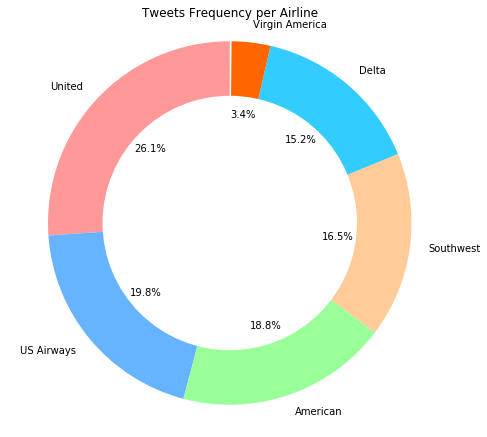

In [8]:
#pie chart of tweets frequency for each airline
labels = ['United', 'US Airways', 'American', 'Southwest', "Delta", "Virgin America"]
sizes = [0.261, 0.198, 0.188, 0.165, 0.152, 0.0344]

#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', "#33ccff", "#ff6600"]
 
fig1, ax1 = plt.subplots(figsize=(6.5,6))

ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Tweets Frequency per Airline")

In [9]:
#among 14640 tweets, there are 9178 negative tweets, 3099 neutral tweets and 2363 positive tweets
df[["airline", "airline_sentiment"]].groupby("airline_sentiment").count()

,airline
airline_sentiment,
negative,9178
neutral,3099
positive,2363


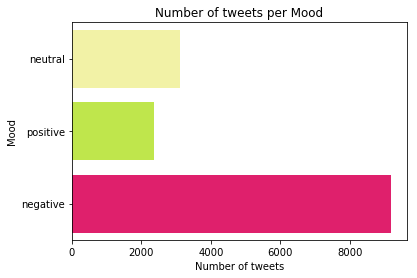

In [10]:
#plot Number of tweets per Mood
sns.countplot(y="airline_sentiment", data=df, palette=['#ffff99','#ccff33', "#ff0066"])
plt.title("Number of tweets per Mood")
plt.xlabel("Number of tweets")
plt.ylabel('Mood')

In [11]:
#look at how customers feels about each airline
pd.crosstab(df.airline, df.airline_sentiment)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


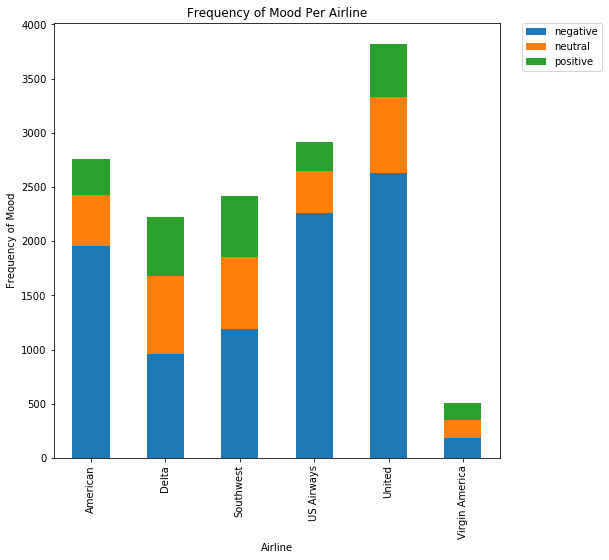

In [12]:
#visualize sentiment per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).plot(kind="bar",
                                                    title='Frequency of Mood Per Airline',
                                                    figsize=(8,8),
                                                    stacked=True)
_.set_xlabel("Airline")
_.set_ylabel("Frequency of Mood")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [13]:
#look at sentiment in precentage per airline
pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1)

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


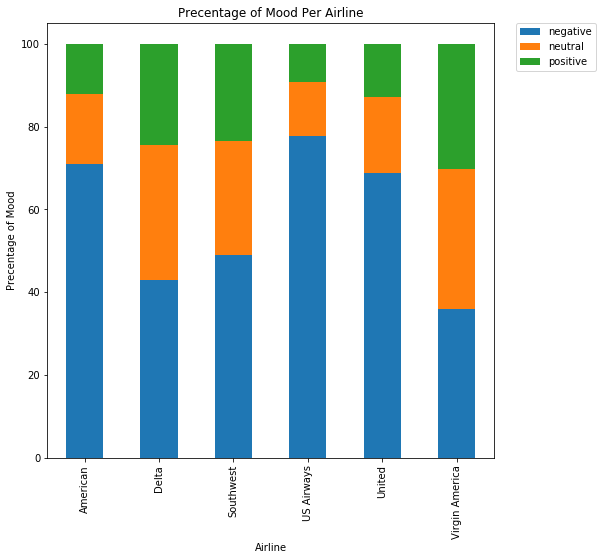

In [14]:
#visualize sentiment in precentage per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind="bar",
       title='Precentage of Mood Per Airline',
       figsize=(8,8),
       stacked=True)
_.set_xlabel("Airline")
_.set_ylabel("Precentage of Mood")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [15]:
#total numbers per negative reasons
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

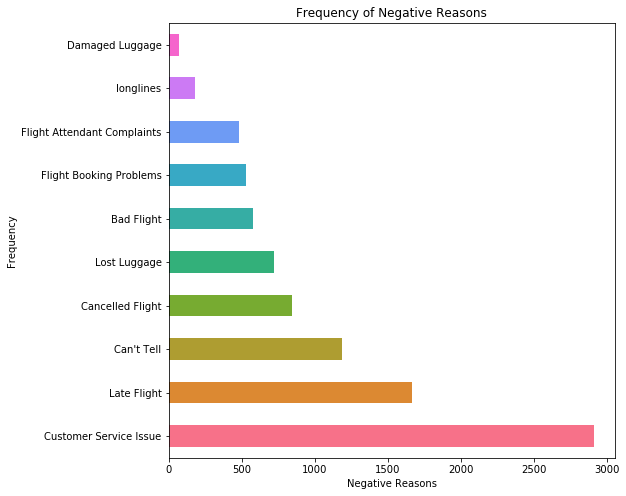

In [16]:
#visualize how many tweets per negative reasons
colors=sns.color_palette("husl",10)
df.negativereason.value_counts().plot(kind="barh",
                                      color = [colors],
                                      figsize=(8,8),
                                      title="Frequency of Negative Reasons")
plt.xlabel('Negative Reasons')
plt.ylabel('Frequency')

In [17]:
#negative reasons per airline
pd.crosstab(df.airline, df.negativereason)

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,87,198,246,768,12,87,130,249,149,34
Delta,64,186,51,199,11,60,44,269,57,14
Southwest,90,159,162,391,14,38,61,152,90,29
US Airways,104,246,189,811,11,123,122,453,154,50
United,216,379,181,681,22,168,144,525,269,48
Virgin America,19,22,18,60,4,5,28,17,5,3


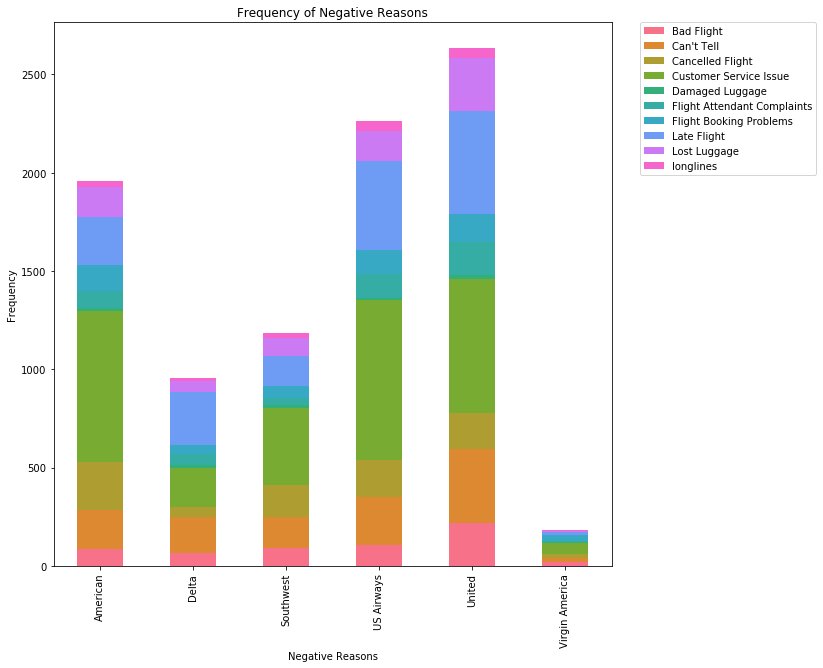

In [18]:
#vizualize negaive reason per airline
colors=sns.color_palette("husl",10)
pd.crosstab(df.airline, df.negativereason).plot(kind="bar",
                                      color = colors,
                                      figsize=(10,10),
                                      stacked=True,
                                      title="Frequency of Negative Reasons")
plt.xlabel('Negative Reasons')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [19]:
#viewing negative reasons in precentage per airline
pd.crosstab(df.airline, df.negativereason).apply(lambda x: x/x.sum() * 100, axis=1)

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
airline,,,,,,,,,,
American,4.438776,10.102041,12.551020,39.183673,0.612245,4.438776,6.632653,12.704082,7.602041,1.734694
Delta,6.701571,19.476440,5.340314,20.837696,1.151832,6.282723,4.607330,28.167539,5.968586,1.465969
Southwest,7.588533,13.406408,13.659359,32.967960,1.180438,3.204047,5.143339,12.816189,7.588533,2.445194
US Airways,4.595669,10.870526,8.351745,35.837384,0.486080,5.435263,5.391074,20.017676,6.805126,2.209456
United,8.203570,14.394227,6.874288,25.864033,0.835549,6.380555,5.469047,19.939233,10.216483,1.823016
Virgin America,10.497238,12.154696,9.944751,33.149171,2.209945,2.762431,15.469613,9.392265,2.762431,1.657459


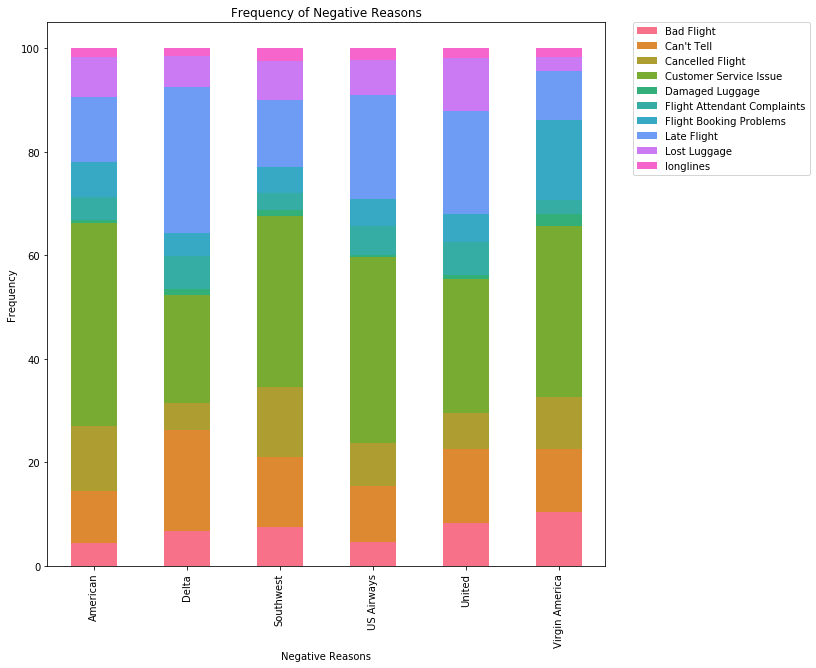

In [20]:
#visualize negative reasons in precentage per airline
#looks like Customer Service Issue is the most important negative for all airlines
colors=sns.color_palette("husl",10)
pd.crosstab(df.airline, df.negativereason).apply(lambda x: x/x.sum() * 100, axis=1).plot(kind="bar",
                                      color = colors,
                                      figsize=(10,10),
                                      stacked=True,
                                      title="Frequency of Negative Reasons")
plt.xlabel('Negative Reasons')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [21]:
#these are the top 5 negative reasons
df.negativereason.value_counts().sort_values(ascending=False).head(5)

Customer Service Issue    2910
Late Flight               1665
Can't Tell                1190
Cancelled Flight           847
Lost Luggage               724
Name: negativereason, dtype: int64

In [22]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [23]:
#take a look how the df.text column is like
df.text.head(20)

0                   @VirginAmerica What @dhepburn said.
1     @VirginAmerica plus you've added commercials t...
2     @VirginAmerica I didn't today... Must mean I n...
3     @VirginAmerica it's really aggressive to blast...
4     @VirginAmerica and it's a really big bad thing...
5     @VirginAmerica seriously would pay $30 a fligh...
6     @VirginAmerica yes, nearly every time I fly VX...
7     @VirginAmerica Really missed a prime opportuni...
8       @virginamerica Well, I didn't…but NOW I DO! :-D
9     @VirginAmerica it was amazing, and arrived an ...
10    @VirginAmerica did you know that suicide is th...
11    @VirginAmerica I &lt;3 pretty graphics. so muc...
12    @VirginAmerica This is such a great deal! Alre...
13    @VirginAmerica @virginmedia I'm flying your #f...
14                               @VirginAmerica Thanks!
15        @VirginAmerica SFO-PDX schedule is still MIA.
16    @VirginAmerica So excited for my first cross c...
17    @VirginAmerica  I flew from NYC to SFO las

In [24]:
username = '@[A-Za-z0-9]+'
url = 'https?://[^ ]+'
link = 'www.[^ ]+'
combined_p = '|'.join((username, url, link))
neg_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg = re.compile('\b(' + '|'.join(neg_dic.keys()) + ')\b')
tok = WordPunctTokenizer()

def tweet_cleaner(text):
    stripped = re.sub(combined_p, '', text) #deal with words start with @ and links 
    lower_case = stripped.lower()
    neg_handled = neg.sub(lambda x: neg_dic[x.group()], lower_case)
    letters = re.sub("[^a-zA-Z]", " ", neg_handled) #deal with hashtag and numbers
    words = [x for x in tok.tokenize(letters) if len(x) > 1]
    drop_stopwords = [x for x in words if x not in stopwords.words('english')]
    return (" ".join(drop_stopwords)).strip()

In [26]:
clean_tweets = []
for tweet in df.text:
    clean_tweets.append(tweet_cleaner(tweet))

In [32]:
df['clean_text'] = pd.DataFrame(clean_tweets)

In [27]:
clean_tweets[0:10]

['said',
 'plus added commercials experience tacky',
 'today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing',
 'seriously would pay flight seats playing really bad thing flying va',
 'yes nearly every time fly vx ear worm go away',
 'really missed prime opportunity men without hats parody',
 'well',
 'amazing arrived hour early good']

### TextBlob

In [28]:
# Use the polarity as y in text classification
polarity = []
for tweet in clean_tweets:
    print tweet
    analysis = TextBlob(tweet)
    print analysis.sentiment
    polarity.append(analysis.sentiment.polarity)

said
Sentiment(polarity=0.0, subjectivity=0.0)
plus added commercials experience tacky
Sentiment(polarity=0.0, subjectivity=0.0)
today must mean need take another trip
Sentiment(polarity=-0.3125, subjectivity=0.6875)
really aggressive blast obnoxious entertainment guests faces amp little recourse
Sentiment(polarity=0.0062500000000000056, subjectivity=0.35)
really big bad thing
Sentiment(polarity=-0.3499999999999999, subjectivity=0.3833333333333333)
seriously would pay flight seats playing really bad thing flying va
Sentiment(polarity=-0.5166666666666666, subjectivity=0.6666666666666666)
yes nearly every time fly vx ear worm go away
Sentiment(polarity=0.45, subjectivity=0.65)
really missed prime opportunity men without hats parody
Sentiment(polarity=0.2, subjectivity=0.2)
well
Sentiment(polarity=0.0, subjectivity=0.0)
amazing arrived hour early good
Sentiment(polarity=0.4666666666666666, subjectivity=0.6)
know suicide second leading cause death among teens
Sentiment(polarity=0.0, subjec

In [29]:
df['polarity'] = pd.DataFrame(polarity)
df['sentiment'] = np.where(df['polarity'] < 0.0, 1, 0)

In [30]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,polarity,sentiment
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0.00000,0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),0.00000,0
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),-0.31250,1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0.00625,0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),-0.35000,1


### WordCloud

In [33]:
wc_string = df['clean_text'].str.cat(sep=' ')

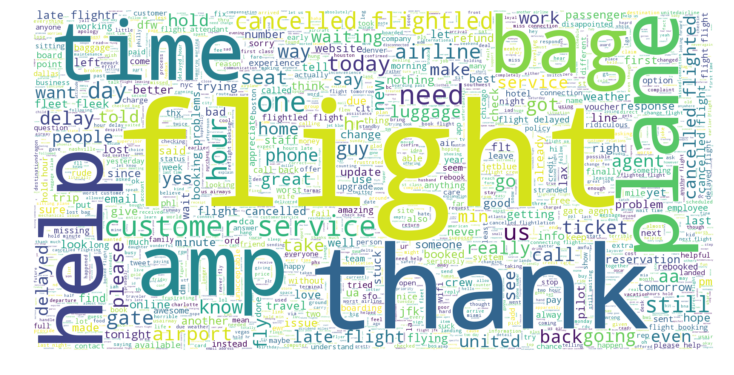

In [34]:
wc = WordCloud(width=1600, height=800,background_color="white", max_words=2000).generate(wc_string)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [35]:
pos_string = df[df.sentiment == 0]['clean_text'].str.cat(sep=' ')

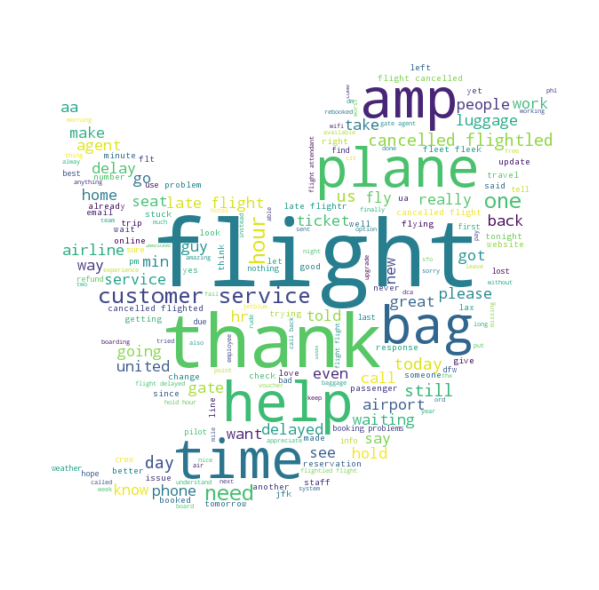

In [37]:
twitter_mask = np.array(Image.open("social-twitter-bird-symbol_318-27588.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", mask=twitter_mask).generate(wc_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [38]:
neg_string = df[df.sentiment == 1]['clean_text'].str.cat(sep=' ')

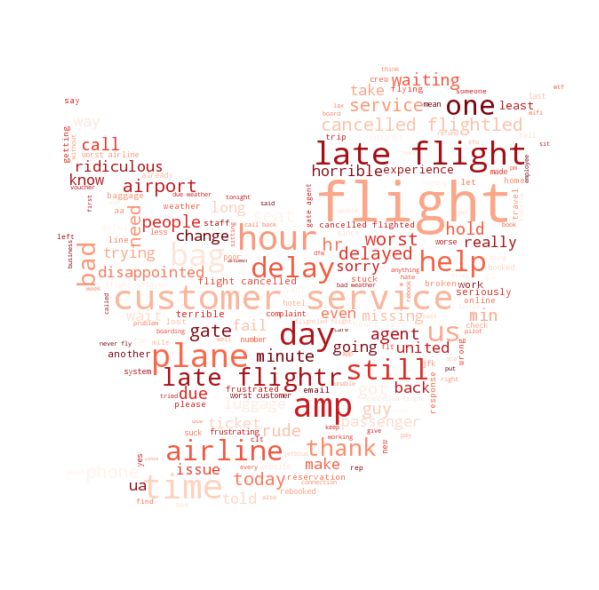

In [39]:
twitter_mask = np.array(Image.open("social-twitter-bird-symbol_318-27588.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Reds",mask=twitter_mask).generate(neg_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Text Classification with Naive Bayes Classifier

In [40]:
df['Sentiment'] = np.where(df['sentiment'] == 1, 'neg', 'pos')

In [43]:
df2 = np.column_stack((df.clean_text, df.Sentiment)).tolist()
train, test = train_test_split(df2, train_size=0.8)
cl = NaiveBayesClassifier(train)

In [44]:
cl.accuracy(test)

0.8770491803278688